In [10]:
from dsc80_utils import *

# Lecture 6 – Hypothesis Testing

## DSC 80, Summer 2025

There was an important <b><a href="https://dsc-courses.github.io/dsc80-2024-wi/resources/lectures/lec06/pre-lec06.html"><span style="color:#7b40c7">Pre-Lecture Reading</span></a></span></b> for this lecture – we'll assume you've done it.

### Announcements 📣

- Project 1 is due on **August 16thh**.


### Agenda 📆

- Data scope.
- Overview of hypothesis testing.
- Example: Total variation distance.
- Permutation testing.
    - Example: Birth weight and smoking 🚬.
    - Example (that you'll read on your own): Permutation testing meets TVD.

### Why are we learning hypothesis testing again?

You may say,

> Didn't we already learn this in DSC 10?

Yes, but:

- It's an important concept, but one that's confusing to understand the first time you learn about it.

- In addition, in order to properly handle missing values (next lecture), we need to learn how to identify different **missingness mechanisms**. Doing so requires performing a hypothesis test.

## Data scope

### Where are we in the data science lifecycle?

<center><img src="imgs/ds-lifecycle.svg" width="50%" /></center>

Hypothesis testing is a tool for helping us **understand the world (some population)**, given our **understanding of the data (some sample)**.

### Data scope

- **Statistical inference**: The practice of drawing conclusions about a population, given a sample.

- **Target population**: All elements of the population you ultimately want to draw conclusions about.

- **Access frame**: All elements that are accessible for you for measurement and observation.

- **Sample**: The subset of the access frame that you actually measured / observed.

### Example: Wikipedia awards

A 2012 paper asked:

> If we give awards to Wikipedia contributors, will they contribute more?

To test this question, they took the top 1% of of Wikipedia contributors, excluded those who already received an award, and then took a random sample of 200 contributors.

<center><img src="imgs/WikipediaConstruct.png" width="55%" /></center>

### Example: Who will win the election?

In the 2016 US Presidental Election, most pollsters predicted Clinton to win over Trump, even though Trump ultimately won.

To poll, they randomly selected **potential** voters and asked them a question over the phone.

<center><img src="imgs/ElectionPollConstruct.png" width="55%" /></center>

### 🔑 Key Idea: Random samples look like the access frame they were sampled from!

- This enables statistical inference!

- But keep in mind, random samples look like their access frame, which can be different than the population itself.

### Sampling in practice

In DSC 10, you used a few key functions/methods to draw samples from populations.

- To draw samples from a known sequence (e.g. array or Series), you used `np.random.choice`.

In [11]:
names = np.load(Path('data') / 'names.npy', allow_pickle=True)

# By default, the sampling is done WITH replacement.
np.random.choice(names, 10)

array(['Krish', 'Nida', 'Aile', 'Jonathan', 'Stephanie', 'Nian-Nian',
       'Diego', 'Tianqi', 'Sia', 'Marcus'], dtype=object)

In [12]:
# To sample WITHOUT replacement, set replace=False.
# This is known as "simple random sampling."
np.random.choice(names, 10, replace=False)

array(['Zhenghao', 'Mehak', 'Mihir', 'Niha', 'Eshaan', 'Amelia', 'Sia',
       'Colin', 'Jimmy', 'Lin'], dtype=object)

- The DataFrame `.sample` method also allowed you to draw samples from a known sequence.

In [13]:
# Samples WITHOUT replacement by default (the opposite of np.random.choice).
pd.DataFrame(names, columns=['name']).sample(10)

,name
26,Dylan
69,Minghan
34,Idhant
...,...
112,Zoey
20,Daniel
111,Zhihan


- To sample from a **categorical** distribution, you used `np.random.multinomial`. Note that in the cell below, we don't see `array([50, 50])` every time, and that's due to randomness!

In [14]:
# Draws 100 elements from a population in which 50% are group 0 and 50% are group 1.
# This sampling is done WITH replacement.
# In other words, each sampled element has a 50% chance of being group 0 and a 50% chance of being group 1.
np.random.multinomial(100, [0.5, 0.5])

array([52, 48])

## Overview of hypothesis testing

### What problem does hypothesis testing solve?

Suppose we've performed an experiment, or identified something interesting in our data.

- Say we've created a new vaccine.

- To assess its efficiency, we give one group the vaccine, and another a [placebo](https://en.wikipedia.org/wiki/Placebo). 

- We notice that the flu rate among those who received the vaccine is lower than among those who received the placebo (i.e. didn't receive the vaccine).

- One possibility: the vaccine doesn't actually do anything, and by chance, those with the vaccine happened to have a lower flu rate.

- Another possibility: receiving the vaccine made a difference – the flu rate among those who received the vaccine is lower than we'd expect due to random chance.

- **Hypothesis testing allows us to determine whether an observation is "significant."**

### Why hypothesis testing is difficult to learn

- It's like "[proof by contradiction](https://brilliant.org/wiki/contradiction/#:~:text=Proof%20by%20contradiction%20(also%20known,the%20opposite%20must%20be%20true.)."

- If I want to show that my vaccine works, I consider a world where it doesn't (null hypothesis).

- Then, I "attack the baseline" by showing that under the null hypothesis my data would be very unlikely.

- Showing something is not true is a lot easier than showing something is true!

### The hypothesis testing "recipe"

Faced with a question about the data raised by an observation...

1. Decide on null and alternate hypotheses.
    - The null hypothesis should be a well-defined probability model that reflects the baseline you want to compare against.
    - The alternative hypothesis should be the "alternate reality" that you suspect may be true.

2. Decide on a **test statistic**, such that a large observed statistic would point to one hypothesis and a small observed statistic would point to the other.

3. Compute an empirical distribution of the test statistic under the null by drawing samples from the null hypothesis' probability model.

4. Assess whether the observed test statistic is consistent with the empirical distribution of the test statistic by computing a **p-value**.

<center>
<img src="imgs/hyp-test-observed.svg" width="60%"/>
<img src="imgs/hyp-test-sampling-dist.svg" width="60%" />
</center>

<div class="alert alert-success" markdown="1">
    <h3>Exercise</h3>
    
Spend some time discussing [**Problem 10 from the Spring 2023 DSC 10 Final Exam**](https://practice.dsc10.com/sp23-final/index.html#problem-10).

It focuses on the art 🎨 of choosing an appropriate test statistic.

</div>

## Example: Total variation distance

### Ethnic distribution of California vs. UCSD

The DataFrame below contains the ethnic breakdown of the state as a whole ([source](https://www.ppic.org/publication/californias-population/)) and UCSD as of 2016 ([source](https://ir.ucsd.edu/_files/stats-data/enrollment/ugethnic.pdf)).

In [15]:
eth = pd.DataFrame(
    [['Asian', 0.15, 0.51],
     ['Black', 0.05, 0.02],
     ['Latino', 0.39, 0.16],
     ['White', 0.35, 0.2],
     ['Other', 0.06, 0.11]],
    columns=['Ethnicity', 'California', 'UCSD']
).set_index('Ethnicity')

eth

,California,UCSD
Ethnicity,,
Asian,0.15,0.51
Black,0.05,0.02
Latino,0.39,0.16
White,0.35,0.20
Other,0.06,0.11


- The two distributions above are clearly different.

- One possibility: UCSD students **do** look like a random sample of California residents, and the distributions above look different purely due to random chance.

- Another possibility: UCSD students **don't** look like a random sample of California residents, because the distributions above look too different.

### Is the difference between the two distributions significant?

Let's establish our hypotheses.
- **Null Hypothesis**: UCSD students **were** selected at random from the population of California residents.
- **Alternative Hypothesis**: UCSD students **were not** selected at random from the population of California residents.
- **Observation**: Ethnic distribution of UCSD students.
- **Test Statistic**: We need a way of quantifying **how different** two categorical distributions are.

In [17]:
# Needed to add renderer
import plotly.io as pio

# Notebook 7 (new Jupyter) – best bet:
pio.renderers.default = "plotly_mimetype"


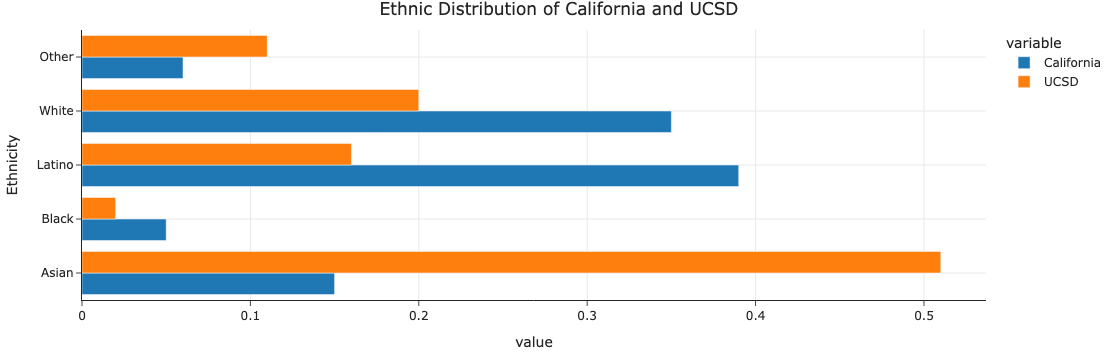

In [18]:
eth.plot(kind='barh', title='Ethnic Distribution of California and UCSD', barmode='group')

How can we summarize the difference, or **distance**, between these two distributions using just a single number?

### Total variation distance

The total variation distance (TVD) is a test statistic that describes the **distance between two categorical distributions**.

If $A = [a_1, a_2, ..., a_k]$ and $B = [b_1, b_2, ..., b_k]$ are both categorical distributions, then the TVD between $A$ and $B$ is

$$\text{TVD}(A, B) = \frac{1}{2} \sum_{i = 1}^k \big|a_i - b_i\big|$$

Let's compute the TVD between UCSD's ethnic distribution and California's ethnic distribution. We _could_ define a function to do this (and you can use this in assignments):

```py
def tvd(dist1, dist2):
    return np.abs(dist1 - dist2).sum() / 2
```

But let's try and work on the `eth` DataFrame directly, using the `diff` method.

In [58]:
# The diff method finds the differences of consecutive elements in a Series.
pd.Series([4, 5, -2]).diff()

0    NaN
1    1.0
2   -7.0
dtype: float64

In [60]:
observed_tvd = eth.diff(axis=1).abs().sum().iloc[1] / 2
observed_tvd

np.float64(0.41000000000000003)

The issue is we don't know whether this is a large value or a small value – we don't know where it lies in the **distribution of TVDs under the null**.

### The plan

To conduct our hypothesis test, we will:

- Repeatedly generate samples of size 30,000 (the number of UCSD students) from the ethnic distribution of all of California.

- Each time, compute the TVD between the simulated distribution and California's distribution.

- **This will generate an empirical distribution of TVDs, under the null.**

- Finally, determine whether the observed TVD (0.41) is consistent with the empirical distribution of TVDs.

### Generating one random sample

Again, to sample from a categorical distribution, we use `np.random.multinomial`.

**Important**: We must sample from the "population" distribution here, which is the ethnic distribution of everyone in California.

In [61]:
# Number of students at UCSD in this example.
N_STUDENTS = 30_000

In [62]:
eth['California']

Ethnicity
Asian     0.15
Black     0.05
Latino    0.39
White     0.35
Other     0.06
Name: California, dtype: float64

In [63]:
np.random.multinomial(30000, eth['California'])

array([ 4511,  1491, 11782, 10469,  1747])

In [24]:
np.random.multinomial(N_STUDENTS, eth['California']) / N_STUDENTS

array([0.15, 0.05, 0.39, 0.35, 0.06])

### Generating many random samples and computing TVDs, without a `for`-loop

We _could_ write a `for`-loop to repeat the process on the previous slide repeatedly (and you _can_ in labs and projects). However, the [Pre-Lecture Reading](https://dsc-courses.github.io/dsc80-2024-wi/resources/lectures/lec06/pre-lec06.html) told us about the `size` argument in `np.random.multinomial`, so let's use that here.

In [66]:
eth_draws = np.random.multinomial(N_STUDENTS, eth['California'], size=100_000) / N_STUDENTS
eth_draws

array([[0.15, 0.05, 0.39, 0.36, 0.06],
       [0.15, 0.05, 0.39, 0.35, 0.06],
       [0.15, 0.05, 0.39, 0.35, 0.06],
       ...,
       [0.15, 0.05, 0.39, 0.35, 0.06],
       [0.15, 0.05, 0.39, 0.35, 0.06],
       [0.15, 0.05, 0.39, 0.35, 0.06]])

In [67]:
eth_draws.shape

(100000, 5)

Notice that each row of `eth_draws` sums to 1, because each row is a simulated categorical distribution.

In [68]:
# The values here appear rounded.
tvds = np.abs(eth_draws - eth['California'].to_numpy()).sum(axis=1) / 2
tvds

array([0.01, 0.  , 0.01, ..., 0.  , 0.  , 0.  ])

### Visualizing the empirical distribution of the test statistic

In [69]:
observed_tvd

np.float64(0.41000000000000003)

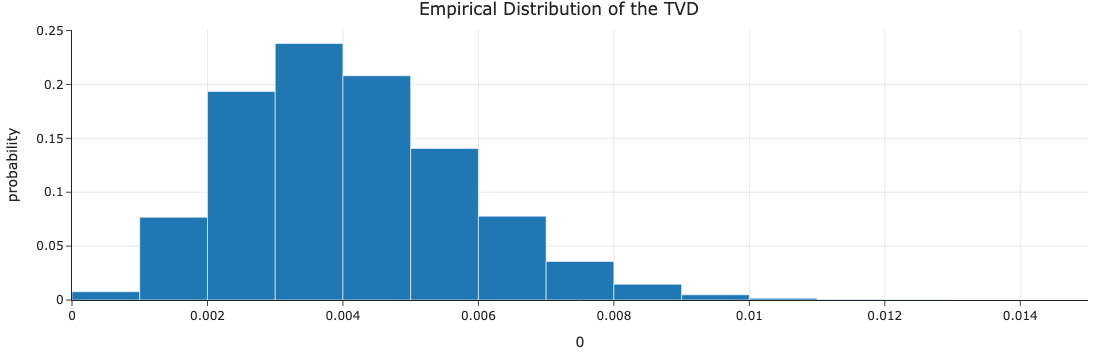

In [70]:
fig = px.histogram(pd.DataFrame(tvds), x=0, nbins=20, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig

In [71]:
(np.array(tvds) >= observed_tvd).mean()

np.float64(0.0)

No, there's not a mistake in our code!

### Conclusion

- The chance that the observed TVD came from the distribution of TVDs under the null is essentially 0.
- This matches our intuition from the start – the two distributions looked very different to begin with. But now we're quite sure the difference can't be explained solely due to chance.

<center>
    <img src="imgs/hyp-test-observed.svg" width="60%" />
    <img src="imgs/hyp-test-tvd.svg" width="60%" />
</center

### Summary of the method

To assess whether an "observed sample" was drawn randomly from a known categorical distribution:
* Use the TVD as the test statistic because it measures the distance between two categorical distributions.
* Sample at random from the population. Compute the TVD between each random sample and the known distribution to get an idea for what reasonable deviations from the eligible pool look like. Repeat this process many, many times.
* Compare:
    - the empirical distribution of TVDs, with
    - the observed TVD from the sample.

### Aside

- It was probably obvious that the difference is significant even before running a hypothesis test.

- Why? There are 30,000 students. Such a difference in proportion is unlikely to be due to random chance – there's something more systematic at play.

- But what if `N_STUDENTS = 300`, `N_STUDENTS = 30`, or `N_STUDENTS=3`?

In [32]:
eth

,California,UCSD
Ethnicity,,
Asian,0.15,0.51
Black,0.05,0.02
Latino,0.39,0.16
White,0.35,0.20
Other,0.06,0.11


In [33]:
def ethnicity_test(N_STUDENTS):
    eth_draws = np.random.multinomial(N_STUDENTS, eth['California'], size=100_000) / N_STUDENTS
    tvds = np.sum(np.abs(eth_draws - eth['California'].to_numpy()), axis=1) / 2
    return (np.array(tvds) >= observed_tvd).mean()

In [34]:
for i in range(1, 9):
    N_STUDENTS = 2 ** i
    print(f'With {N_STUDENTS} students, the p-value is {ethnicity_test(N_STUDENTS)}.')

With 2 students, the p-value is 0.72928.
With 4 students, the p-value is 0.30703.
With 8 students, the p-value is 0.08051.
With 16 students, the p-value is 0.00387.
With 32 students, the p-value is 0.0.
With 64 students, the p-value is 0.0.
With 128 students, the p-value is 0.0.
With 256 students, the p-value is 0.0.


<div class="alert alert-warning">
    <h3>Question 🤔 (Answer at <a href="https://docs.google.com/forms/d/e/1FAIpQLScWbVZv9hBv-wX-ItKHUVRnkPMMtfJZVfErKE9GS7_8dFcRBQ/viewform">q.dsc80.com)</h3>
</div>
    
What questions do you have?

## Permutation testing

### Hypothesis testing vs. permutation testing

- So far, we've used hypothesis tests to answer questions of the form:

> I have a population distribution, and I have one sample. Does this sample look like it was drawn from the population?

- Next, we want to consider questions of the form:

> I have two samples, but no information about any population distributions. Do these samples look like they were drawn from the same population? That is, do these two samples look "similar"?

### Hypothesis testing vs. permutation testing

<br>

<center>
<img src="imgs/hyp-test-observed.svg" width="60%"/>
<img src="imgs/hyp-test-sampling-dist.svg" width="60%"/>
</center>

This framework requires us to be able to draw samples from the baseline population – but what if we don't know that population?

### Example: Birth weight and smoking 🚬

For familiarity, we'll start with an example from DSC 10. This means we'll move quickly!

Let's start by loading in the data. Each row corresponds to a mother/baby pair.

In [36]:
baby = pd.read_csv(Path('data') / 'babyweights.csv')
baby

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
...,...,...,...,...,...,...
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False
1173,117,297,38,65,129,False


We're only interested in the `'Birth Weight'` and `'Maternal Smoker'` columns.

In [37]:
baby = baby[['Maternal Smoker', 'Birth Weight']]
baby.head()

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136


Note that there are **two samples**:
- Birth weights of smokers' babies (rows where `'Maternal Smoker'` is `True`).
- Birth weights of non-smokers' babies (rows where `'Maternal Smoker'` is `False`).

### Exploratory data analysis

How many babies are in each group? What is the average birth weight within each group?

In [38]:
baby.groupby('Maternal Smoker')['Birth Weight'].agg(['mean', 'count'])

,mean,count
Maternal Smoker,,
False,123.09,715
True,113.82,459


Note that 16 ounces are in 1 pound, so the above weights are ~7-8 pounds.

### Visualizing birth weight distributions

Below, we draw the distributions of both sets of birth weights.

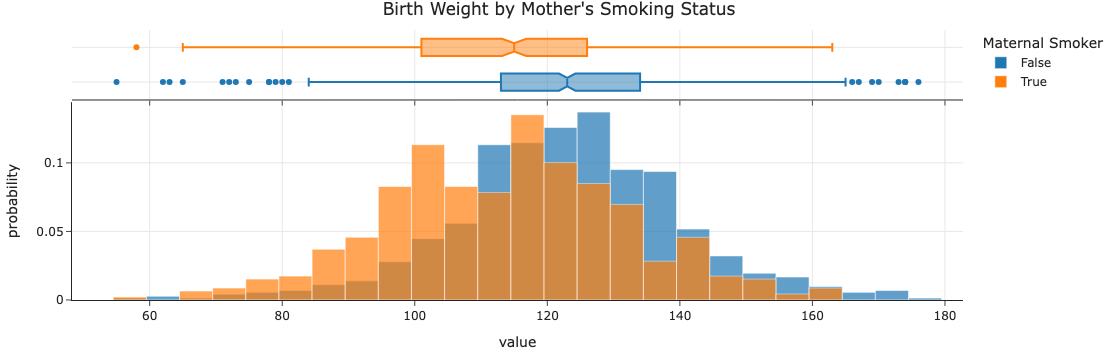

In [39]:
fig = px.histogram(baby, color='Maternal Smoker', histnorm='probability', marginal='box', 
                   title="Birth Weight by Mother's Smoking Status", barmode='overlay', opacity=0.7)
fig

There appears to be a difference, but can it be attributed to random chance?

### Null hypothesis: birth weights come from the *same* distribution

- Our null hypothesis states that "smoker" / "non-smoker" labels have no relationship to birth weight. 
- In other words, the "smoker" / "non-smoker" labels **may well have** been assigned at random.

<center><img src='imgs/null-hyp.png' width=60%><br><i>DGP stands for "data generating process" – think of this as another word for population.</i></center>

### Alternative hypothesis: birth weights come from *different* distributions

- Our alternative hypothesis states that the birth weights weights of smokers' babies and non-smokers' babies come from different population distributions.
    - That is, they come from different data generating processes.
- It also states that smokers' babies weigh significantly less.

<center><img src='imgs/alt-hyp.png' width=40%></center>

### Choosing a test statistic

We need a test statistic that can measure **how different** two numerical distributions are.

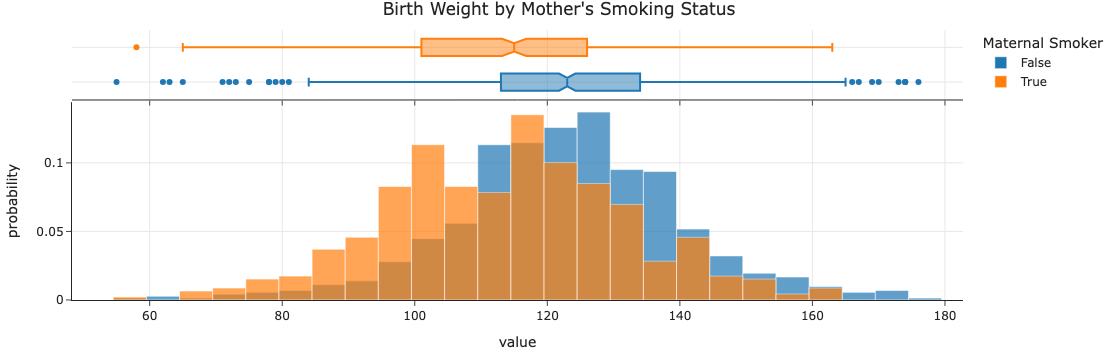

In [40]:
fig = px.histogram(baby, color='Maternal Smoker', histnorm='probability', marginal='box', 
                   title="Birth Weight by Mother's Smoking Status", barmode='overlay', opacity=0.7)
fig

**Easiest solution**: Difference in group means.

### Difference in group means

We'll choose our test statistic to be:

$$\text{mean weight of smokers' babies} - \text{mean weight of non-smokers' babies}$$

We could also compute the non-smokers' mean minus the smokers' mean, too.

In [41]:
group_means = baby.groupby('Maternal Smoker')['Birth Weight'].mean()
group_means

Maternal Smoker
False    123.09
True     113.82
Name: Birth Weight, dtype: float64

At first, you may think to use `loc` with `group_means` to compute the difference in group means.

In [42]:
group_means.loc[True] - group_means.loc[False]

np.float64(-9.266142572024918)

However, you can also use the `diff` method, as we saw earlier.

In [43]:
group_means.diff()

Maternal Smoker
False     NaN
True    -9.27
Name: Birth Weight, dtype: float64

In [44]:
group_means.diff().iloc[-1]

np.float64(-9.266142572024918)

In [46]:
# If we wanted to do (non-smokers' mean - smokers' mean). 
# Think about why this is the case (hint: it has to do with how the resulting DataFrame after grouping is sorted).
group_means[::-1].diff().iloc[-1]

np.float64(9.266142572024918)

### Hypothesis test setup

- **Null Hypothesis**: In the population, birth weights of smokers' babies and non-smokers' babies have the same distribution, and the observed differences in our samples are due to random chance.

- **Alternative Hypothesis**: In the population, smokers' babies have lower birth weights than non-smokers' babies, on average. The observed difference in our samples cannot be explained by random chance alone.

- **Test Statistic**: Difference in group means.

$$\text{mean weight of smokers' babies} - \text{mean weight of non-smokers' babies}$$

- **Issue**: We don't know what the population distribution actually is – so how do we draw samples from it?
    - This is different from the coin flipping, and the California ethnicity examples, because there **the null hypotheses were well-defined probability models**.

### Implications of the null hypothesis

- Under the null hypothesis, both groups are sampled from the same distribution.
- If this is true, then the group label – `'Maternal Smoker'` – has no effect on the birth weight.
- In our dataset, we saw **one assignment** of `True` or `False` to each baby.

In [ ]:
baby.head()

- Under the null hypothesis, we were just as likely to see **any other** assignment.

### Permutation tests

- In a **permutation test**, we generate new data by **shuffling group labels**.
    - In our current example, this involves randomly assigning **babies to `True` or `False`**, while keeping the same number of `True`s and `False`s as we started with.

- On each shuffle, we'll compute our test statistic (difference in group means).

- If we shuffle many times and compute our test statistic each time, we will approximate the distribution of the test statistic.

- We can them compare our observed statistic to this distribution, as in any other hypothesis test.

### Shuffling

- Our goal, by shuffling, is to randomly assign values in the `'Maternal Smoker'` column to values in the `'Birth Weight'` column.

- We can do this by shuffling either column **independently**.

- Easiest solution: `np.random.permutation`.
    - We could also use `df.sample`, but it's more complicated (and slower).

In [47]:
np.random.permutation(baby['Birth Weight'])

array([143, 145, 121, ..., 137,  98, 154])

In [51]:
with_shuffled = baby.assign(Shuffled_Weights=np.random.permutation(baby['Birth Weight']))
with_shuffled.head()

,Maternal Smoker,Birth Weight,Shuffled_Weights
0,False,120,139
1,False,113,117
2,True,128,145
3,True,108,122
4,False,136,122


Now, we have a new sample of smokers' weights, and a new sample of non-smokers' weights!

Effectively, we took a random sample of 459 `'Birth Weights'` and assigned them to the smokers' group, and the remaining 715 to the non-smokers' group.

### How close are the means of the shuffled groups?

One benefit of shuffling `'Birth Weight'` (instead of `'Maternal Smoker'`) is that grouping by `'Maternal Smoker'` allows us to see all of the following information with a single call to `groupby`.

In [52]:
group_means = with_shuffled.groupby('Maternal Smoker').mean()
group_means

,Birth Weight,Shuffled_Weights
Maternal Smoker,,
False,123.09,119.89
True,113.82,118.80


Let's visualize both pairs of distributions – what do you notice?

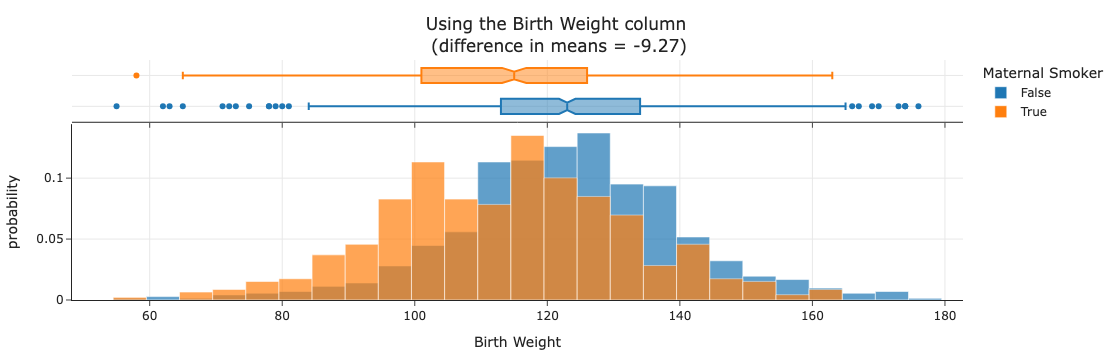

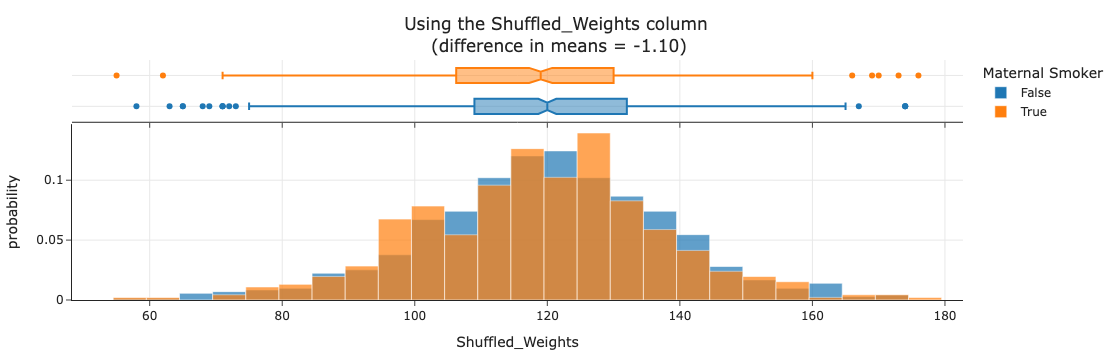

In [53]:
for x in ['Birth Weight', 'Shuffled_Weights']:
    fig = px.histogram(
        with_shuffled, x=x, color='Maternal Smoker', histnorm='probability', marginal='box', 
        title=f"Using the {x} column <br>(difference in means = {group_means[x].diff().iloc[-1]:.2f})",
        barmode='overlay', opacity=0.7)
    fig.update_layout(margin=dict(t=60))
    fig.show()

### Simulating the empirical distribution of the test statistic

- This was just one random shuffle.

- The question we are trying to answer is, **how likely is it that a random shuffle results in two samples where the difference in group means (smoker minus non-smoker) is $\geq$ 9.26?**

- To answer this question, we need the distribution of the test statistic. To generate that, we must shuffle many, many times. On each iteration, we must:
    1. Shuffle the weights and store them in a DataFrame.
    1. Compute the test statistic (difference in group means).
    1. Store the result.

In [54]:
n_repetitions = 500

differences = []
for _ in range(n_repetitions):
    
    # Step 1: Shuffle the weights and store them in a DataFrame.
    with_shuffled = baby.assign(Shuffled_Weights=np.random.permutation(baby['Birth Weight']))

    # Step 2: Compute the test statistic.
    # Remember, False (0) comes before True (1),
    # so this computes True - False.
    group_means = (
        with_shuffled
        .groupby('Maternal Smoker')
        .mean()
        .loc[:, 'Shuffled_Weights']
    )
    difference = group_means.diff().iloc[-1]
    
    # Step 4: Store the result
    differences.append(difference)
    
differences[:10]

[np.float64(-0.7809040632570117),
 np.float64(0.7823544647074101),
 np.float64(1.043493761140823),
 np.float64(0.7143867026220079),
 np.float64(0.9826805003275609),
 np.float64(0.6929231988055449),
 np.float64(0.3960113960114029),
 np.float64(-0.9848073495132326),
 np.float64(1.0864207687737064),
 np.float64(-0.4625287566464067)]

We already computed the observed statistic earlier, but we compute it again below to keep all of our calculations together.

In [55]:
observed_difference = baby.groupby('Maternal Smoker')['Birth Weight'].mean().diff().iloc[-1]
observed_difference

np.float64(-9.266142572024918)

### Conclusion of the test

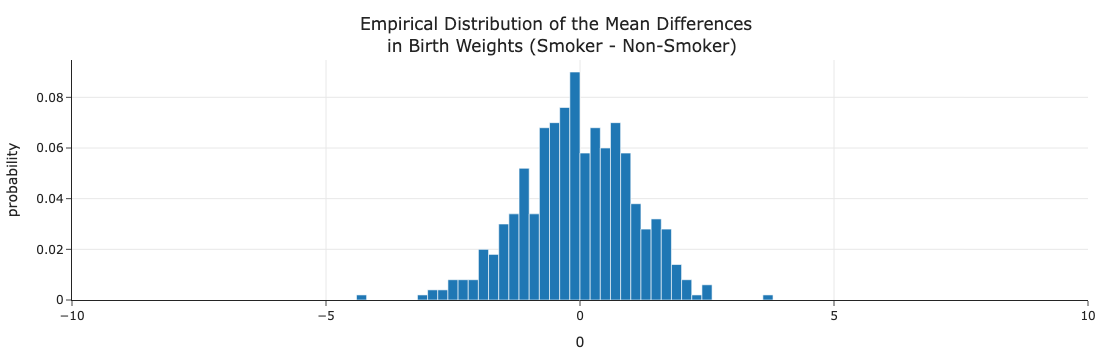

In [57]:
fig = px.histogram(
    pd.DataFrame(differences), x=0, nbins=50, histnorm='probability', 
    title='Empirical Distribution of the Mean Differences <br> in Birth Weights (Smoker - Non-Smoker)')
fig.add_vline(x=observed_difference, line_color='red')
fig.update_layout(xaxis_range=[-10, 10], margin=dict(t=60))

- Under the null hypothesis, we rarely see differences as large as 9.26 ounces.

- Therefore, **we reject the null hypothesis that the two groups come from the same distribution**. That is, the difference between the two samples is statistically significant.

### ⚠️ Caution!

- We **cannot** conclude that smoking **causes** lower birth weight!
- This was an observational study; there may be confounding factors.
    - Maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.

### Hypothesis testing vs. permutation testing

- Permutation tests **are** hypothesis tests!

- "Standard" hypothesis tests answer questions of the form:

> I have a population distribution, and I have one sample. Does this sample look like it was drawn from the population?

- Permutation tests answer questions of the form:

> I have two samples, but no information about any population distributions. Do these samples look like they were drawn from the same population? That is, do these two samples look "similar"?

<div class="alert alert-warning">
    <h3>Breakout </h3>
</div>
    
_This question was taken from the Spring 2022 Midterm Exam._
    
Consider the following pair of hypotheses.

- **Null Hypothesis**: The average GPA of UC San Diego admits from La Jolla Private is equal to the average GPA of UC San Diego admits from all schools.

- **Alternative Hypothesis**: The average GPA of UC San Diego admits from La Jolla Private is less than the average GPA of UC San Diego admits from all schools.

What type of test is this?

- A. Standard hypothesis test
- B. Permutation test

<div class="alert alert-warning">
    <h3>Question 🤔 </h3>
</div>
    
_This question was taken from the Spring 2022 Midterm Exam._

    
Consider the following pair of hypotheses.

- **Null Hypothesis**: The distribution of admitted, waitlisted, and rejected students at UC San Diego from Warren High is equal to the distribution of admitted, waitlisted, and rejected students at UC San Diego from La Jolla Private.

- **Alternative Hypothesis**: The distribution of admitted, waitlisted, and rejected students at UC San Diego from Warren High is different from the distribution of admitted, waitlisted, and rejected students at UC San Diego from La Jolla Private.



What type of test is this?

- A. Standard hypothesis test
- B. Permutation test

## Summary, next time

### Summary

- Both "standard" hypothesis tests and permutation tests are forms of hypothesis tests, which are used to assess whether some observation in our data looks **significant**.
    - See the end of the "Permutation testing" section for the distinction between the two.
- To run a hypothesis test, we need to choose a **test statistic** such that large observed values point to one hypothesis and small observed values point to the other. Examples we've seen:
    - Number of heads, absolute difference between number of heads and expected number of heads (coin-flipping example in the pre-lecture reading).
    - Total variation distance.
    - Difference in group means.

### Next time

Identifying different ways in which data can be missing. Don't worry, hypothesis testing will be revisited!

## Permutation testing meets TVD

<div class="alert alert-warning" markdown="1">
    
<h3>

Note: We aren't going to cover the following example in lecture, but you need to read it!  You can also watch [**this podcast, starting from 4:43**](https://podcast.ucsd.edu/watch/wi23/dsc80_a00/11), for a 
walkthrough of it.

</h3>
    
</div>

### Example: Married vs. unmarried couples

* We will use data from a study conducted in 2010 by the [National Center for Family and Marriage Research](https://www.bgsu.edu/ncfmr.html).
* The data consists of a national random sample of over 1,000 heterosexual couples who were either married or living together but unmarried.
* Each row corresponds to one **person** (not one couple).

In [ ]:
couples = pd.read_csv(Path('data') / 'married_couples.csv')
couples.head()

In [ ]:
# What does this expression compute?
couples['hh_id'].value_counts().value_counts()

We won't use all of the columns in the DataFrame.

In [ ]:
couples = couples[['mar_status', 'empl_status', 'gender', 'age']]
couples.head()

### Cleaning the dataset

The numbers in the DataFrame correspond to the mappings below.

* `'mar_status'`: 1=married, 2=unmarried.
* `'empl_status'`: enumerated in the list below.
* `'gender'`: 1=male, 2=female.
* `'age'`: person's age in years.

In [ ]:
couples.head()

In [ ]:
empl = [
    'Working as paid employee',
    'Working, self-employed',
    'Not working - on a temporary layoff from a job',
    'Not working - looking for work',
    'Not working - retired',
    'Not working - disabled',
    'Not working - other'
]

In [ ]:
couples = couples.replace({
    'mar_status': {1: 'married', 2: 'unmarried'},
    'gender': {1: 'M', 2: 'F'},
    'empl_status': {(k + 1): empl[k] for k in range(len(empl))}
})

In [ ]:
couples.head()

### Understanding the `couples` dataset

* Who is in our dataset? Mostly young people? Mostly married people? Mostly employed people?
* What is the distribution of values in each column?

In [ ]:
# For categorical columns, this shows the 10 most common values and their frequencies.
# For numerical columns, this shows the result of calling the .describe() method.
for col in couples:
    if couples[col].dtype == 'object':
        empr = couples[col].value_counts(normalize=True).to_frame().iloc[:10]
    else:
        empr = couples[col].describe().to_frame()
    display(empr)

Let's look at the distribution of age **separately** for married couples and unmarried couples.

In [ ]:
px.histogram(couples, x='age', color='mar_status', histnorm='probability', marginal='box',
             barmode='overlay', opacity=0.7)

How are these two distributions different? Why do you think there is a difference?

### Understanding employment status in households

* Do married households more often have a stay-at-home spouse?
* Do households with unmarried couples more often have someone looking for work?
* How much does the employment status of the different households vary?

To answer these questions, let's compute the distribution of employment status **conditional on household type (married vs. unmarried)**.

In [ ]:
couples.sample(5).head()

In [ ]:
# Note that this is a shortcut to picking a column for values and using aggfunc='count'.
empl_cnts = couples.pivot_table(index='empl_status', columns='mar_status', aggfunc='size')
empl_cnts

Since there are a different number of married and unmarried couples in the dataset, we can't compare the numbers above directly. We need to convert counts to proportions, separately for married and unmarried couples.

In [ ]:
empl_cnts.sum()

In [ ]:
cond_distr = empl_cnts / empl_cnts.sum()
cond_distr

Both of the columns above sum to 1.

### Differences in the distributions

Are the distributions of employment status for married people and for unmarried people who live with their partners **different**?

Is this difference just due to noise?

In [ ]:
cond_distr.plot(kind='barh', title='Distribution of Employment Status, Conditional on Household Type', barmode='group')

### Permutation test for household composition 

* **Null Hypothesis**: In the US, the distribution of employment status among those who are married is the same as among those who are unmarried and live with their partners. The difference between the two observed samples is due to chance.

* **Alternative Hypothesis**: In the US, the distributions of employment status of the two groups are **different**.

### Total variation distance

- Whenever we need to compare two categorical distributions, we use the TVD.
    - Recall, the TVD is the **sum of the absolute differences in proportions, divided by 2**.
- In DSC 10, the only test statistic we ever used in permutation tests was the difference in group means/medians, but the TVD can be used in permutation tests as well.

In [ ]:
cond_distr

Let's first compute the observed TVD:

In [ ]:
(cond_distr['unmarried'] - cond_distr['married']).abs().sum() / 2

Since we'll need to calculate the TVD repeatedly, let's define a function that computes it.

In [ ]:
def tvd_of_groups(df, groups, cats):
    '''groups: the binary column (e.g. married vs. unmarried).
       cats: the categorical column (e.g. employment status).
    '''
    cnts = df.pivot_table(index=cats, columns=groups, aggfunc='size')
    # Normalize each column.
    distr = cnts / cnts.sum()
    # Compute and return the TVD.
    return (distr['unmarried'] - distr['married']).abs().sum() / 2

In [ ]:
# Same result as above.
observed_tvd = tvd_of_groups(couples, groups='mar_status', cats='empl_status')
observed_tvd

### Simulation

- Under the null hypothesis, marital status is not related to employment status.
- We can shuffle the marital status column and get an equally-likely dataset.
- On each shuffle, we will compute the TVD.
- Once we have many TVDs, we can ask, **how often do we see a difference at least as large as our observed difference?**

In [ ]:
couples.head()

Here, we'll shuffle marital statuses, though remember, we could shuffle employment statuses too.

In [ ]:
couples.assign(shuffled_mar=np.random.permutation(couples['mar_status']))

Let's do this repeatedly.

In [ ]:
N = 1000
tvds = []

for _ in range(N):
    # Shuffle marital statuses.
    with_shuffled = couples.assign(shuffled_mar=np.random.permutation(couples['mar_status']))
    
    # Compute and store the TVD.
    tvd = tvd_of_groups(with_shuffled, groups='shuffled_mar', cats='empl_status')
    tvds.append(tvd)

Notice that by defining a function that computes our test statistic, our simulation code is much cleaner.

### Conclusion of the test

In [ ]:
fig = px.histogram(tvds, x=0, nbins=50, histnorm='probability', 
                   title='Empirical Distribution of the TVD')
fig.update_layout(xaxis_range=[0, 0.2])

We **reject** the null hypothesis that married/unmarried households have similar employment makeups.

We can't say anything about **why** the employment makeups are different, though!